# ecMINN-reservoir

This notebook implements an **ecMINN** using a **reservoir computing** approach to predict and analyze metabolic fluxes.

#### Key Components:

* **Model Type:** AMN (amn_qp_divided_loss) with a reservoir configuration.
* **Dataset:** `ref_fluxes_pec_iAF1260`.
* **GEM (Genome-scale Metabolic Model):** `iAF1260_ec_duplicated` (6,542 reactions, 2,929 species).
* **Optimization:** Uses GLPK for constraint-based modeling through the CBMPy framework.
* **Goal:** Training and validating the network to predict reaction fluxes while monitoring metrics like , MAE, and RMSE.

In [1]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
import pandas as pd
from src.nn_model.amn_qp import *
from src.utils.hpo import hpo
from src.utils.import_data import *
from src.utils.import_GEM import *
from src.utils.training import *
from src.utils.plots import *
from src.utils.utils import *
from hydra import initialize, compose
from omegaconf import OmegaConf
import logging

# hydra in jupyter notebook
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

config_dir = "conf" # Adjust path
initialize(config_path=config_dir, job_name="notebook_logging", version_base="1.1")

# HERE YOU CAN DECIDE WHICH CONFIGURATION FILE TO LOG
# 

cfg = compose(config_name="MINN_reservoir_pec") 

# Step 3: Log the configuration
logger.info("Logging configuration:")
logger.info(OmegaConf.to_yaml(cfg))



# No clearML when using jupyter
task= None
# reproduciblility
seed = cfg.seed
fix_random_seed(seed=seed)

# load gem and data
n_distribution= cfg.gem.n_total_reactions
X, y, Vin, fit_model, reference = load_ishii(seed=seed, 
                                                dataset=cfg.dataset.dataset_name,
                                                fluxes_removed_from_reference=cfg.dataset.fluxes_removed_from_reference,
                                                fluxes_to_add_input = cfg.dataset.fluxes_to_add_input,
                                                kos_genes= cfg.dataset.kos_genes,
                                                gem = cfg.gem.gem_name)

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Lists to store results for each LOO iteration
Q2_loo = []
MAE_loo = []
RMSE_loo = []
NE_loo = []

# List to store single left out predictions
Vref_true_loo = []
Vref_pred_loo = []
Vpred_final = []
Vin_reservoir_final = []
list_SV_loss_per_sample = []

total_run= 29
count = 1
for train_idx, val_idx in loo.split(X):
    # Extract the training and validation data
    X_train, y_train, Vin_train = X[train_idx], y[train_idx], Vin[train_idx]
    X_val, y_val, Vin_val = X[val_idx], y[val_idx], Vin[val_idx]

    # kfolf cross validation 
    #best_params = hpo(cfg, task=task, X_train=X_train, y_train=y_train, Vin_train=Vin_train, n_distribution=n_distribution, fit_model=fit_model)
    best_params = {'hidden_size': 1000, 'drop_rate': 0.1, 'learning_rate': 1e-5, 'weight_decay': 0.0001, 'l1_constant': 25}
    # train and test using the best hyperparameters found with the kfold
    results = train_test_evaluation(cfg, task, X_train, X_val, y_train, y_val, Vin_train, Vin_val, n_distribution, fit_model, best_params, loo_count=count)
    

    # Inverse transform targets to extract metrics
    Vref_pred_te = np.matmul(np.array(results["test"]['Vref_pred']), fit_model.Pref.T)
    Vref_true = results["test"]['Vref_true']
    
    
    # save metrics in the a list (one for each left out observation)
    Q2_value = r2_metric(np.array(Vref_true), Vref_pred_te)
    Q2_loo.append(Q2_value)

    MAE_value = np.mean(np.abs(Vref_true-Vref_pred_te))
    MAE_loo.append(MAE_value)

    RMSE_value = np.sqrt(np.mean(np.square(Vref_true-Vref_pred_te)))
    RMSE_loo.append(RMSE_value)

    NE_value = np.nan_to_num(np.linalg.norm(Vref_true - Vref_pred_te) / np.linalg.norm(Vref_true), posinf=0, neginf=0, nan=0)
    NE_loo.append(NE_value)

    Vref_true_loo.append(np.array(Vref_true).flatten())
    Vref_pred_loo.append(np.array(Vref_pred_te).flatten())
    Vpred_final.append(np.array(results["test"]['Vref_pred']).flatten())
    Vin_reservoir_final.append(np.array(results["test"]['Vin_reservoir']).flatten())
    

    print(f'run {count}/{total_run}')
    print(f'Loss Train: {results["train"]["losses"]}')
    print(f'Loss Test: {results["test"]["losses"]}')
    print(f'Q²:{Q2_value}')
    print(f'MAE:{MAE_value}')
    print(f'RMSE {RMSE_value}')
    print(f'NE:{NE_value}')
    
    list_SV_loss_per_sample.append(results["test"]["losses"][1])
    count += 1

Namespace(Qp_iteration=8, prior_knowledge=False, exp_name='test', L1='MSE', model='AMN', device='cuda:0')
pyparsing import
CBGLPK based on swiglpk: not all methods implimented yet! 5.0



No module named 'cplex'



CPLEX not available

*****
Using GLPK
*****

doFBAMinSum not available with GLPK


***********************************************************************
* Welcome to CBMPy (0.8.8) - PySCeS Constraint Based Modelling        *
*       https://systemsbioinformatics.github.io/cbmpy/                *
* Copyright (C) Brett G. Olivier, 2014 - 2024                         *
* Systems Biology Lab, A-LIFE, AIMMS, Faculty of Science              *
* Vrije Universiteit Amsterdam, Amsterdam, The Netherlands            *
* This version of CBMPy distributed under the GNU GPL v 3.0 licence   *
***********************************************************************



INFO:__main__:Logging configuration:
INFO:__main__:dataset:
  dataset_name: ref_fluxes_pec_iAF1260
  fluxes_removed_from_reference:
  - R_usage_prot_P0A9C3
  - R_usage_prot_P36938
  - R_usage_prot_P0A6T1
  - R_usage_prot_P06999
  - R_usage_prot_P0A993
  - R_usage_prot_P0AB71
  - R_usage_prot_P0A858
  - R_usage_prot_P0A9B2
  - R_usage_prot_P0A799
  - R_usage_prot_P62707
  - R_usage_prot_P0A6P9
  - R_usage_prot_P21599
  - R_usage_prot_P0AD61
  - R_usage_prot_P23538
  - R_usage_prot_P0AC53
  - R_usage_prot_P52697
  - R_usage_prot_P00350
  - R_usage_prot_P0AG07
  - R_usage_prot_P0A7Z0
  - R_usage_prot_P27302
  - R_usage_prot_P33570
  - R_usage_prot_P0A867
  - R_usage_prot_P0A870
  - R_usage_prot_P0A955
  - R_usage_prot_P0AFG8
  - R_usage_prot_P06959
  - R_usage_prot_P0A9P0
  - R_usage_prot_P22259
  - R_usage_prot_P00864
  - R_usage_prot_P0ABH7
  - R_usage_prot_P36683
  - R_usage_prot_P0AFG6
  - R_usage_prot_P0A836
  - R_usage_prot_P0AGE9
  - R_usage_prot_P0AC41
  - R_usage_prot_P07014
  - 

Attempting to load SBML file: GEMs/iAF1260_ec_duplicated.xml
SBML Level 3 FBC version 2 model detected, loading with cbmpy.readSBML3FBC()
FBC version: 2
M.getNumReactions: 6542
M.getNumSpecies: 2929
FBC.getNumObjectives: 1
FBC.getNumParameters: 6541
FBC.getNumGeneProducts: 1262
Zero dimension compartment detected: c
Zero dimension compartment detected: p
Zero dimension compartment detected: e
FluxBounds process1: 0.113
INFO: Active objective: obj
Adding objective: obj
FluxBounds process2: 0.592
Gene G_standard is not part of a GPR association. Will create anyway!

User defined contraint FBC version 2
SBML3 load time: 5.478

reference: Index(['R_usage_prot_P0A6V8', 'R_usage_prot_P0A796', 'R_usage_prot_P37351',
       'R_usage_prot_P0ADF6', 'R_usage_prot_P25516', 'R_usage_prot_P0AFG3',
       'R_usage_prot_P07003', 'R_usage_prot_P32675', 'R_GLCptspp_for_2',
       'R_PGI_for', 'R_PFK_for_2', 'R_FBA_for', 'R_TPI_for', 'R_PGK_rev',
       'R_ENO_for', 'R_PYK_for_2', 'R_PDH', 'R_PGL', 'R_GN

In [2]:
# Report table - DataFrame with index
if cfg.dataset.dataset_name=='ref_47_fluxes':
    df_true = pd.read_csv('data/ishii_data/fluxomics_iAF1260_reduced_split.csv')[cfg.dataset.metric_fluxes]
    
elif cfg.dataset.dataset_name=='ref_47_fluxes_fit':
    df_true = pd.read_csv('data/ishii_data/fluxomics_iAF1260_reduced_split_fit.csv')[cfg.dataset.metric_fluxes]
elif cfg.dataset.dataset_name=='ref_47_fluxes_ec':
    df_true = pd.read_csv('data/ishii_data/fluxomics_iAF1260_reduced_split.csv')[cfg.dataset.metric_fluxes]
elif cfg.dataset.dataset_name=='ref_fluxes_pec_iAF1260':
    df_true = pd.read_csv('data/ishii_data/fluxomics_pec_iAF1260_projected.csv')[cfg.dataset.metric_fluxes]
else:
    df_true = pd.read_csv('data/ishii_data/fluxomics_ecore_correct.csv')[cfg.dataset.metric_fluxes]


# Report table - DataFrame with index
df_V = pd.DataFrame(Vpred_final, columns=fit_model.reactions)[cfg.dataset.metric_fluxes]


metrics_df = metrics_table(df_true, df_V)
#add row with SV avg and std
avg_SV = np.array(list_SV_loss_per_sample).mean()
std_SV = np.array(list_SV_loss_per_sample).std()
metrics_df.loc["SV loss"] = [avg_SV, std_SV]

metrics_df

,avg,std
Q2,0.790569,0.055601
MAE,0.662452,0.415698
RMSE,0.943188,0.612964
NE,0.418411,0.106750
SV loss,0.000018,0.000018


In [3]:
from datetime import datetime; 
date_now = datetime.now().strftime("%Y%m%d%H%M")
exp_name = f'reservoir_fluxomic_pec_withKO_1_{date_now}'
filename_df_V = f'reservoir/eciAF1260_df_V_{exp_name}.csv'
filename_SV_loss = f'reservoir/eciAF1260_SV_loss_{exp_name}.json'

df_V.to_csv(filename_df_V, index=False)
with open(filename_SV_loss, 'w') as f:
    json.dump(list_SV_loss_per_sample, f, indent=4)

df_V_prot = pd.DataFrame(Vpred_final, columns=fit_model.reactions)[cfg.dataset.fluxes_removed_from_reference]

filename_df_V_prot = f'reservoir/eciAF1260_df_V_prot_{exp_name}.csv'
df_V_prot.to_csv(filename_df_V_prot, index=False)
df_V_all = pd.DataFrame(Vpred_final, columns=fit_model.reactions)
filename_df_V_all = f'reservoir/eciAF1260_df_V_all_{exp_name}.csv'
df_V_all.to_csv(filename_df_V_all, index=False)


filename_metrics = f'reservoir/eciAF1260_metrics_{exp_name}.csv'
metrics_df.to_csv(filename_metrics)

In [13]:
df_V

,R_GLCptspp_for_2,R_PGI_for,R_PFK_for_2,R_FBA_for,R_TPI_for,R_PGK_rev,R_ENO_for,R_PYK_for_2,R_PDH,R_PGL,...,R_LDH_D_rev,R_ALCD2x_rev,R_EX_etoh_e_o,R_EX_ac_e_o,R_EX_lac__D_e_o,R_EX_succ_e_o,R_EX_pyr_e_o,R_EX_for_e_o,R_EX_co2_e_o,R_BIOMASS_Ec_iAF1260_core_59p81M
0,3.054796,0.001305,0.001286,2.533807,2.612560,5.230628,5.053113,0.000848,1.116154,0.000515,...,0.000643,0.000803,0.000879,0.001908,0.199363,0.000945,0.115676,2.254705,0.123726,0.211958
1,2.280012,0.000463,0.001046,1.969726,2.159990,4.141783,4.016005,0.000979,0.783269,0.000181,...,0.000360,0.000904,0.000890,0.001085,0.286557,0.000977,0.009996,1.774219,0.059806,0.143622
2,2.453781,0.002815,0.003356,2.139559,2.239816,4.340415,4.227484,0.002708,0.800628,0.001146,...,0.001642,0.002454,0.002921,0.004354,0.372407,0.003024,0.085978,1.996109,0.129080,0.224063
3,2.804627,0.009652,0.007874,2.435927,2.483626,4.856478,4.742907,0.005094,0.714869,0.004144,...,0.004661,0.004665,0.006136,0.009940,0.283687,0.005978,0.507907,2.438188,0.205383,0.313717
4,3.096008,0.020090,0.014609,2.603240,2.619157,5.283523,5.095273,0.007565,0.741328,0.009750,...,0.008500,0.006830,0.009934,0.015161,0.216951,0.009131,1.189172,2.260094,0.286120,0.388346
5,3.620037,0.005080,0.003553,3.031699,3.031865,6.218496,6.009066,0.001629,0.872487,0.002068,...,0.001827,0.001493,0.002198,0.004111,0.128788,0.001954,0.871418,2.719493,0.207383,0.313938
6,2.561553,0.003502,0.003634,2.197598,2.271590,4.422766,4.289179,0.002741,0.894043,0.001509,...,0.001942,0.002548,0.002962,0.004913,0.300834,0.003103,0.134853,2.080951,0.150225,0.249318
7,2.809147,0.009176,0.007445,2.418580,2.464382,4.839765,4.712903,0.004591,0.739642,0.003918,...,0.004350,0.004292,0.005467,0.009055,0.224915,0.005307,0.500206,2.493500,0.211645,0.315904
8,3.048237,0.001880,0.001808,2.580430,2.661935,5.280017,5.100338,0.001176,0.849133,0.000705,...,0.000895,0.001104,0.001325,0.002431,0.174125,0.001338,0.166801,2.698793,0.132076,0.227168
9,3.311108,0.007008,0.005106,2.764558,2.752951,5.627928,5.449413,0.002462,0.995157,0.003230,...,0.002848,0.002365,0.003174,0.006137,0.159070,0.002973,0.765554,2.321114,0.228078,0.334038


In [8]:
import pandas as pd

df_V_prot_true = pd.read_csv("data/ishii_data/fluxomics_pec_iAF1260_projected.csv")
df_V_prot_true = df_V_prot_true.drop('experiment', axis=1)
df_V_prot_true = df_V_prot_true[cfg.dataset.fluxes_removed_from_reference]
df_V_prot_true

df_pred = df_V_prot
df_meas = df_V_prot_true

violations = (df_pred >= df_meas)

# Count how many violations per enzyme
violation_counts = violations.sum(axis=0)

# Fraction of samples violating per enzyme
violation_fraction = violation_counts / df_pred.shape[0]

# Global fraction of violations
global_fraction = violations.sum().sum() / df_pred.size

print(f"Global fraction of violations: {global_fraction:.3f}")
print(violation_fraction.sort_values(ascending=False))  # top 10 worst enzymes

Global fraction of violations: 0.243
R_usage_prot_P0AC41    1.000000
R_usage_prot_P0A9N4    1.000000
R_usage_prot_P14407    1.000000
R_usage_prot_P0A7Z0    1.000000
R_usage_prot_P52697    1.000000
R_usage_prot_P06999    0.931034
R_usage_prot_P0AG07    0.931034
R_usage_prot_P0AC53    0.689655
R_usage_prot_P21599    0.620690
R_usage_prot_P0AD61    0.620690
R_usage_prot_P0A6T1    0.448276
R_usage_prot_P07014    0.448276
R_usage_prot_P33570    0.344828
R_usage_prot_P0AGE9    0.310345
R_usage_prot_P00350    0.275862
R_usage_prot_P05042    0.241379
R_usage_prot_P08839    0.206897
R_usage_prot_P62707    0.206897
R_usage_prot_P37330    0.206897
R_usage_prot_P0A836    0.172414
R_usage_prot_P27550    0.172414
R_usage_prot_P0A9Q7    0.172414
R_usage_prot_P0A955    0.172414
R_usage_prot_P0A9M8    0.172414
R_usage_prot_P0A799    0.103448
R_usage_prot_P31660    0.068966
R_usage_prot_P0A9C3    0.068966
R_usage_prot_P22259    0.068966
R_usage_prot_P0A858    0.068966
R_usage_prot_P27302    0.068966
R_u

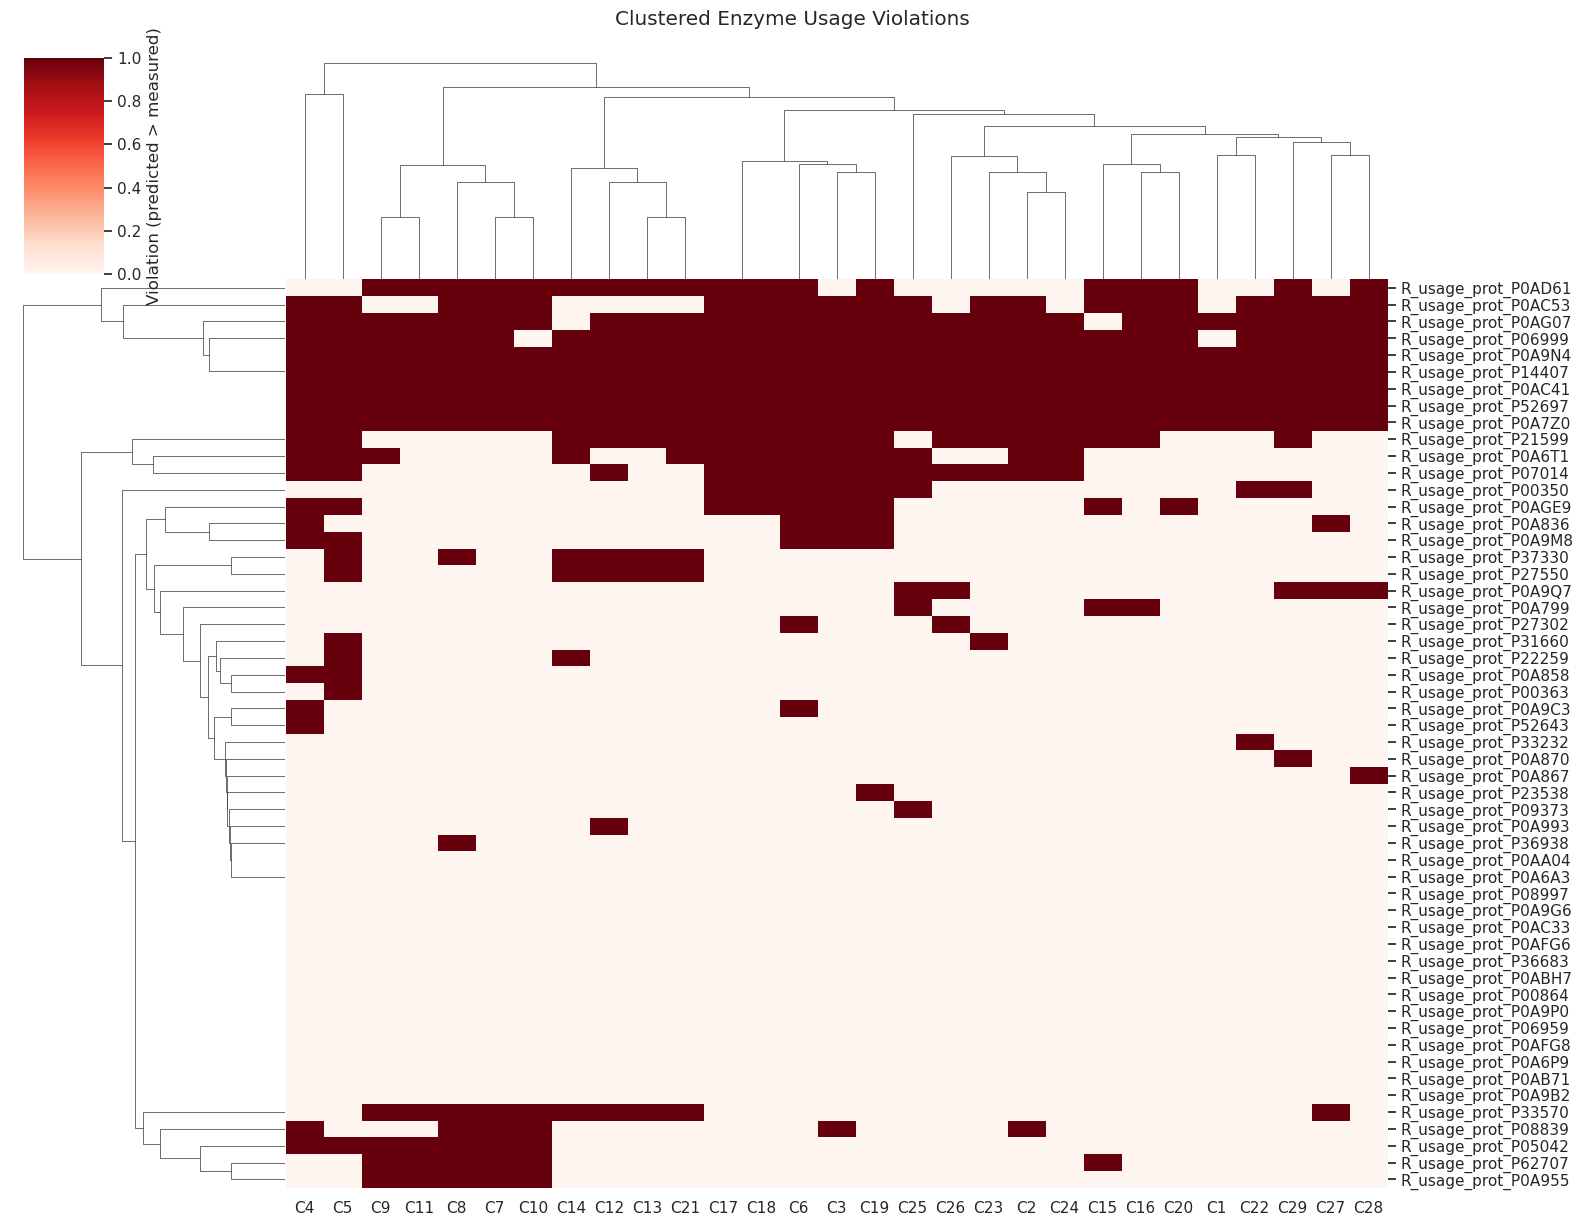

/tmp/ipykernel_2055561/4049044660.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


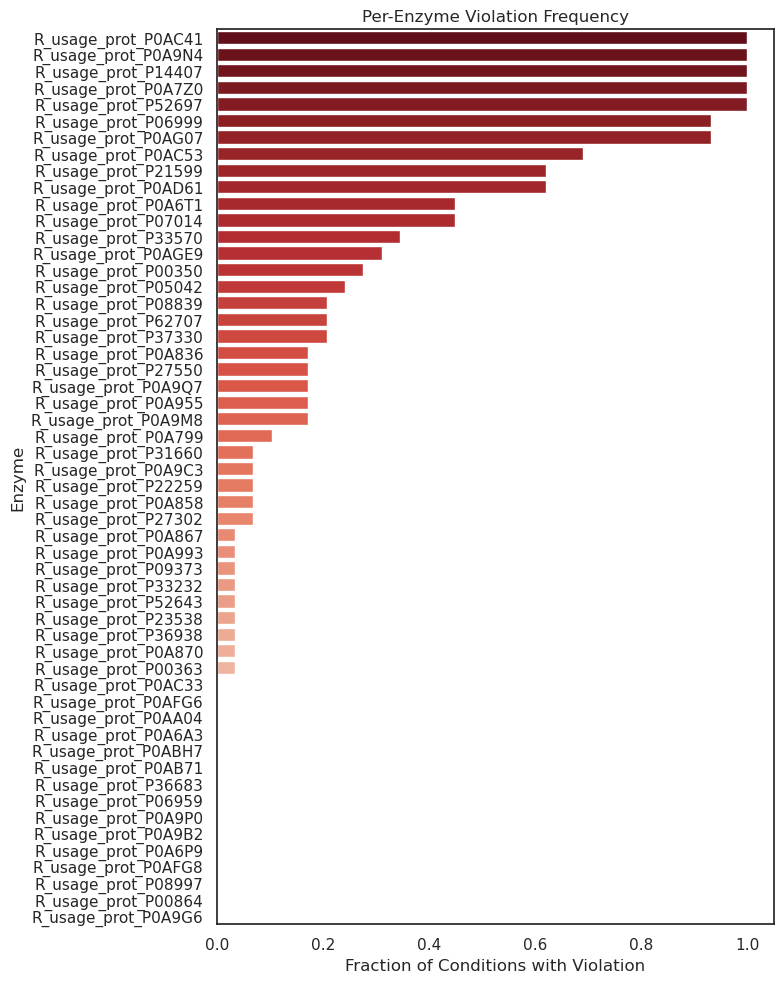

                Enzyme  FractionViolations
0  R_usage_prot_P0AC41            1.000000
1  R_usage_prot_P0A9N4            1.000000
2  R_usage_prot_P14407            1.000000
3  R_usage_prot_P0A7Z0            1.000000
4  R_usage_prot_P52697            1.000000
5  R_usage_prot_P06999            0.931034
6  R_usage_prot_P0AG07            0.931034
7  R_usage_prot_P0AC53            0.689655
8  R_usage_prot_P21599            0.620690
9  R_usage_prot_P0AD61            0.620690


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Input ---
# df_pred = predicted enzyme usage (28 x 54)
# df_meas = measured proteomics (28 x 54)

# Compute violations
violations = (df_pred > df_meas).astype(int)

# ---- 1) Clustered heatmap ----
g = sns.clustermap(
    violations.T,
    cmap="Reds",
    cbar_kws={'label': 'Violation (predicted > measured)'},
    xticklabels=[f"C{i+1}" for i in range(violations.shape[0])],
    yticklabels=violations.columns,
    figsize=(16, 12)
)
plt.suptitle("Clustered Enzyme Usage Violations", y=1.02)
plt.show()

# ---- 2) Violation fraction per enzyme ----
violation_fraction = violations.sum(axis=0) / violations.shape[0]
violation_fraction_sorted = violation_fraction.sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(
    x=violation_fraction_sorted.values,
    y=violation_fraction_sorted.index,
    palette="Reds_r"
)
plt.xlabel("Fraction of Conditions with Violation")
plt.ylabel("Enzyme")
plt.title("Per-Enzyme Violation Frequency")
plt.tight_layout()
plt.show()

# Optional: Save results as DataFrame
violation_summary = violation_fraction_sorted.reset_index()
violation_summary.columns = ["Enzyme", "FractionViolations"]
print(violation_summary.head(10))
